In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from transformers import AutoModelForCausalLM, AutoTokenizer
from types import MethodType

from transformers.models.llama.modeling_llama import apply_rotary_pos_emb

import json



def plot_qk_shared_projection_from_4k_before(
    k_4k_before, q_4k_before,
    k_4k_after, q_4k_after,
    k_64k_before, q_64k_before,
    k_64k_after, q_64k_after,
    title_prefix="Q/K PCA View (Fixed from 4K-before)",
    layer=0, head=0,
):
    """
    Use Q/K 4K-before-RoPE principal component direction, project all to one space
    input:
        k: Tensor [seq_len, dim]
        q: List[Tensor [seq_len, dim]]
    """

    # Step 1: use Q and K for PCA, 
    # k_4k_before&q_4k_before means using the projection from 4k before rope
    # k_4k_after&q_4k_after means using the projection from 4k after rope
    ref_matrix = torch.cat([k_4k_before] + q_4k_before, dim=0)  # [total_tokens, dim]
    pca = PCA(n_components=2)
    pca.fit(ref_matrix.cpu().numpy())
    V_shared = torch.from_numpy(pca.components_.T).to(ref_matrix.device)  # [dim, 2]

    # Step 2: prepare data
    entries = [
        ("4K Before RoPE", k_4k_before, q_4k_before),
        ("4K After RoPE", k_4k_after, q_4k_after),
        ("64K Before RoPE", k_64k_before, q_64k_before),
        ("64K After RoPE", k_64k_after, q_64k_after),
    ]

    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    axs = axs.flatten()

    for i, (title, k, q_list) in enumerate(entries):
        ax = axs[i]

        # project K
        k_proj = k @ V_shared
        ax.scatter(k_proj[:, 0].cpu(), k_proj[:, 1].cpu(), label="K", c='black', s=10, alpha=0.7)

        # peojrct Qs
        for qi, q in enumerate(q_list):
            q_proj = q @ V_shared
            ax.scatter(q_proj[:, 0].cpu(), q_proj[:, 1].cpu(), label=f"Q{qi}", s=10, alpha=0.5)

        ax.set_title(f"{title_prefix} - {title}")
        ax.set_xlabel("PC 1")
        ax.set_ylabel("PC 2")
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.legend()
    plt.show()

/home/azzhang/miniforge3/envs/fms-mo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/azzhang/miniforge3/envs/fms-mo/lib/python3.10/site-packages/transformers/utils/hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [ ]:
# prepare Q,K

model_name = "meta-llama/Meta-Llama-3-8B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", torch_dtype="auto")

with open("/home/azzhang/streaming-llm/output/wikitext2_prompts_llama3.json", "r", encoding="utf-8") as f:
    prompts = json.load(f)
target_length_64k = "64k"
target_length_4k = "4k"

prompt_64k = prompts[target_length_64k]
prompt_4k = prompts[target_length_4k]
inputs_64k = tokenizer(prompt_64k, return_tensors="pt").to(model.device)
inputs_4k = tokenizer(prompt_4k, return_tensors="pt").to(model.device)
seq_len_64 = inputs_64k["input_ids"].shape[1]
seq_len_4 = inputs_4k["input_ids"].shape[1]
print(seq_len_64)
print(seq_len_4)

cache_4k = {}
cache_64k = {}
target_layer = 0 # choose which layer you want check

def patched_forward(self, hidden_states, position_embeddings=None, *args, **kwargs):
    q = self.q_proj(hidden_states)
    k = self.k_proj(hidden_states)
    v = self.v_proj(hidden_states)

    bsz, seqlen, dim = q.shape
    head_dim = self.head_dim
    # num_heads = self.num_heads
    num_heads_q = self.config.num_attention_heads
    num_heads_kv = self.config.num_key_value_heads
    # print(num_heads_q)
    # print(num_heads_kv)
    if seqlen == seq_len_4:
        print(seq_len_4)
        q = q.view(bsz, seqlen, num_heads_q, head_dim).transpose(1, 2)
        k = k.view(bsz, seqlen, num_heads_kv, head_dim).transpose(1, 2)
        

        # Q、K before rope
        cache_4k["q_raw"] = q.detach().cpu()
        cache_4k["k_raw"] = k.detach().cpu()
        

        cos, sin = position_embeddings
        q_rope, k_rope = apply_rotary_pos_emb(q, k, cos, sin)
        cache_4k["q_rope"] = q_rope.detach().cpu()
        cache_4k["k_rope"] = k_rope.detach().cpu()
    else:
        print(seq_len_64)
        q = q.view(bsz, seqlen, num_heads_q, head_dim).transpose(1, 2)
        k = k.view(bsz, seqlen, num_heads_kv, head_dim).transpose(1, 2)

        # Q、K before rope
        cache_64k["q_raw"] = q.detach().cpu()
        cache_64k["k_raw"] = k.detach().cpu()
        
        cos, sin = position_embeddings
        q_rope, k_rope = apply_rotary_pos_emb(q, k, cos, sin)
        cache_64k["q_rope"] = q_rope.detach().cpu()
        cache_64k["k_rope"] = k_rope.detach().cpu()

    
    return self._orig_forward(hidden_states, position_embeddings, *args, **kwargs)

# insert patch
attn_layer = model.model.layers[target_layer].self_attn
attn_layer._orig_forward = attn_layer.forward
attn_layer.forward = MethodType(patched_forward, attn_layer)

with torch.no_grad():
    outputs = model(**inputs_4k)
with torch.no_grad():
    outputs = model(**inputs_64k)

Q_4k = cache_4k["q_raw"].squeeze(0)  # shape: (num_heads, seq_len, head_dim) for one layer (32, 4k, 1024//32)
K_4k = cache_4k["k_raw"].squeeze(0) # (8, 4k, 1024//8)

Q_64k = cache_64k["q_raw"].squeeze(0)  # shape: (num_heads, seq_len, head_dim)
K_64k = cache_64k["k_raw"].squeeze(0)

Q_4k_rope = cache_4k["q_rope"].squeeze(0)  # shape: (num_heads, seq_len, head_dim)
K_4k_rope = cache_4k["k_rope"].squeeze(0)

Q_64k_rope = cache_64k["q_rope"].squeeze(0)  # shape: (num_heads, seq_len, head_dim)
K_64k_rope = cache_64k["k_rope"].squeeze(0)

Loading checkpoint shards: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


65406
3964
3964
65406


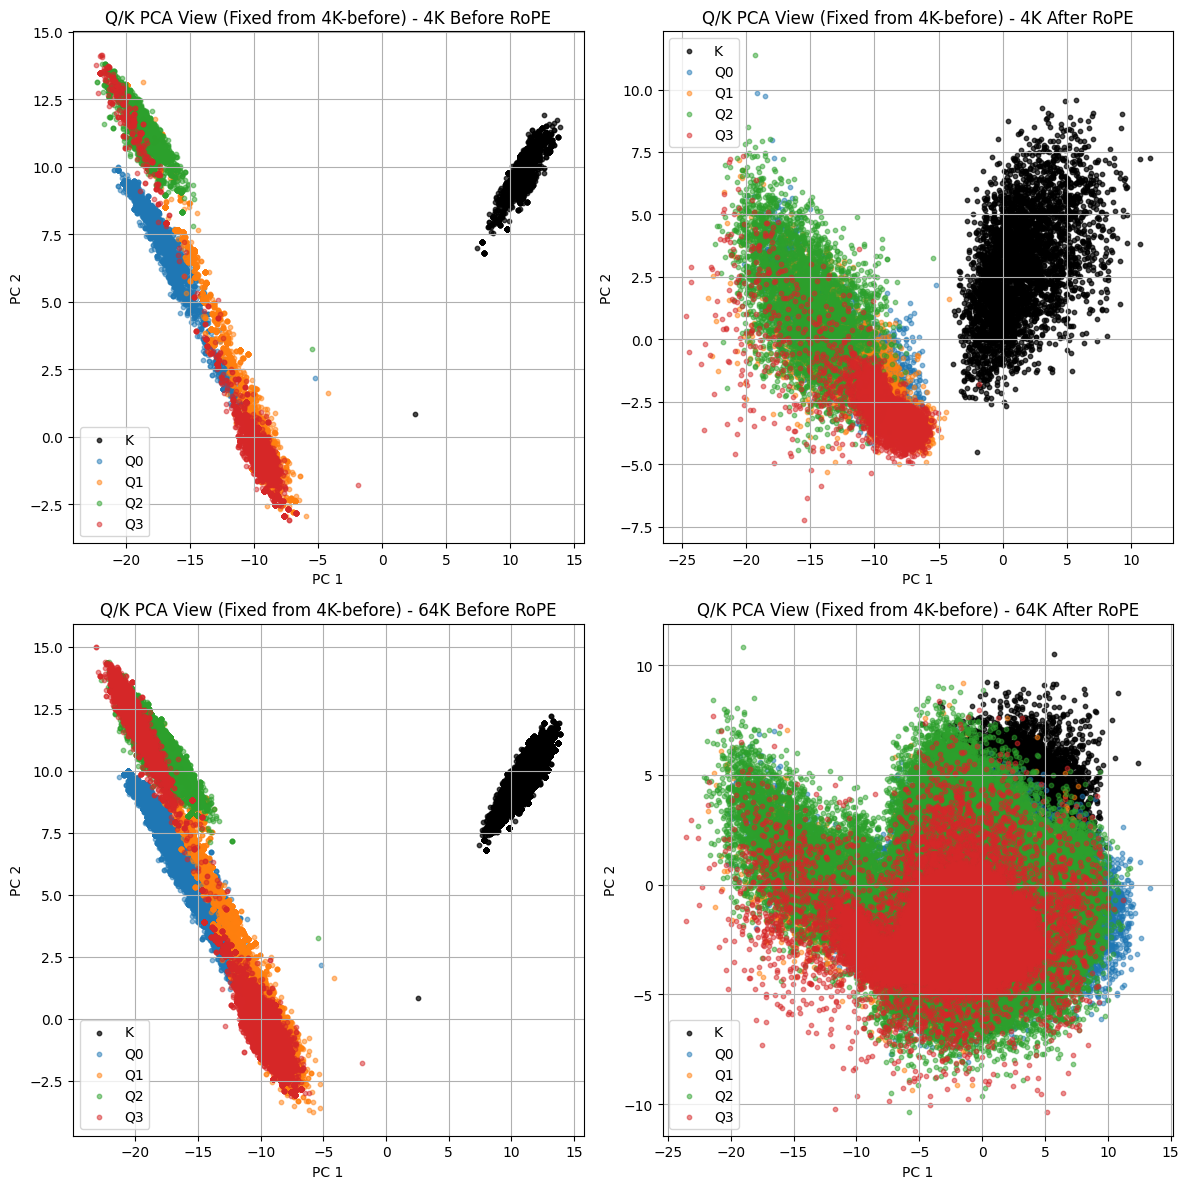

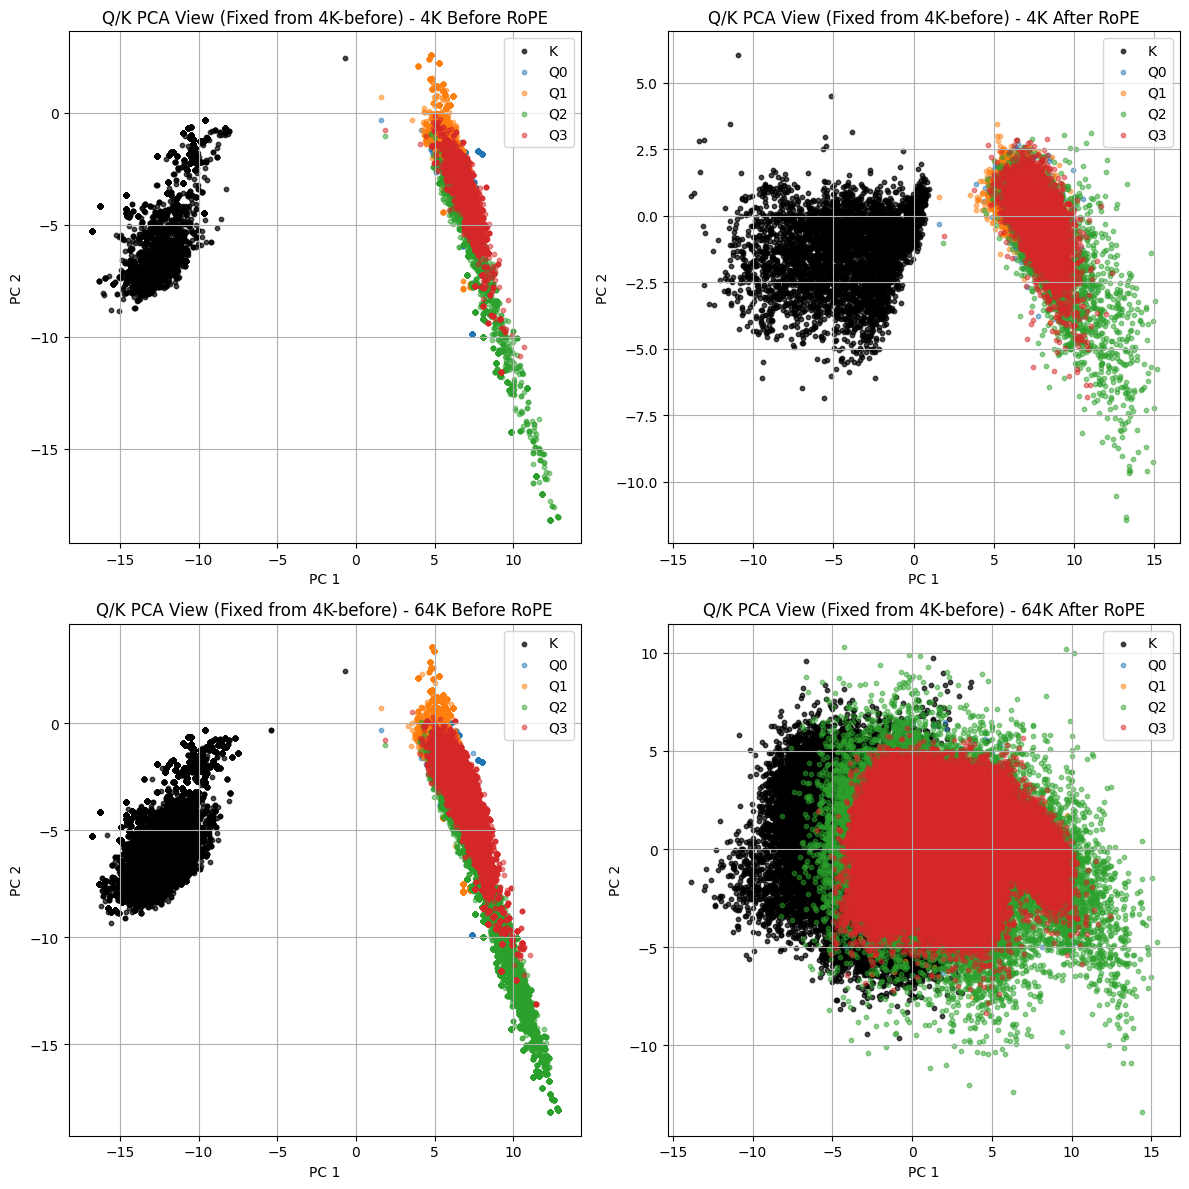

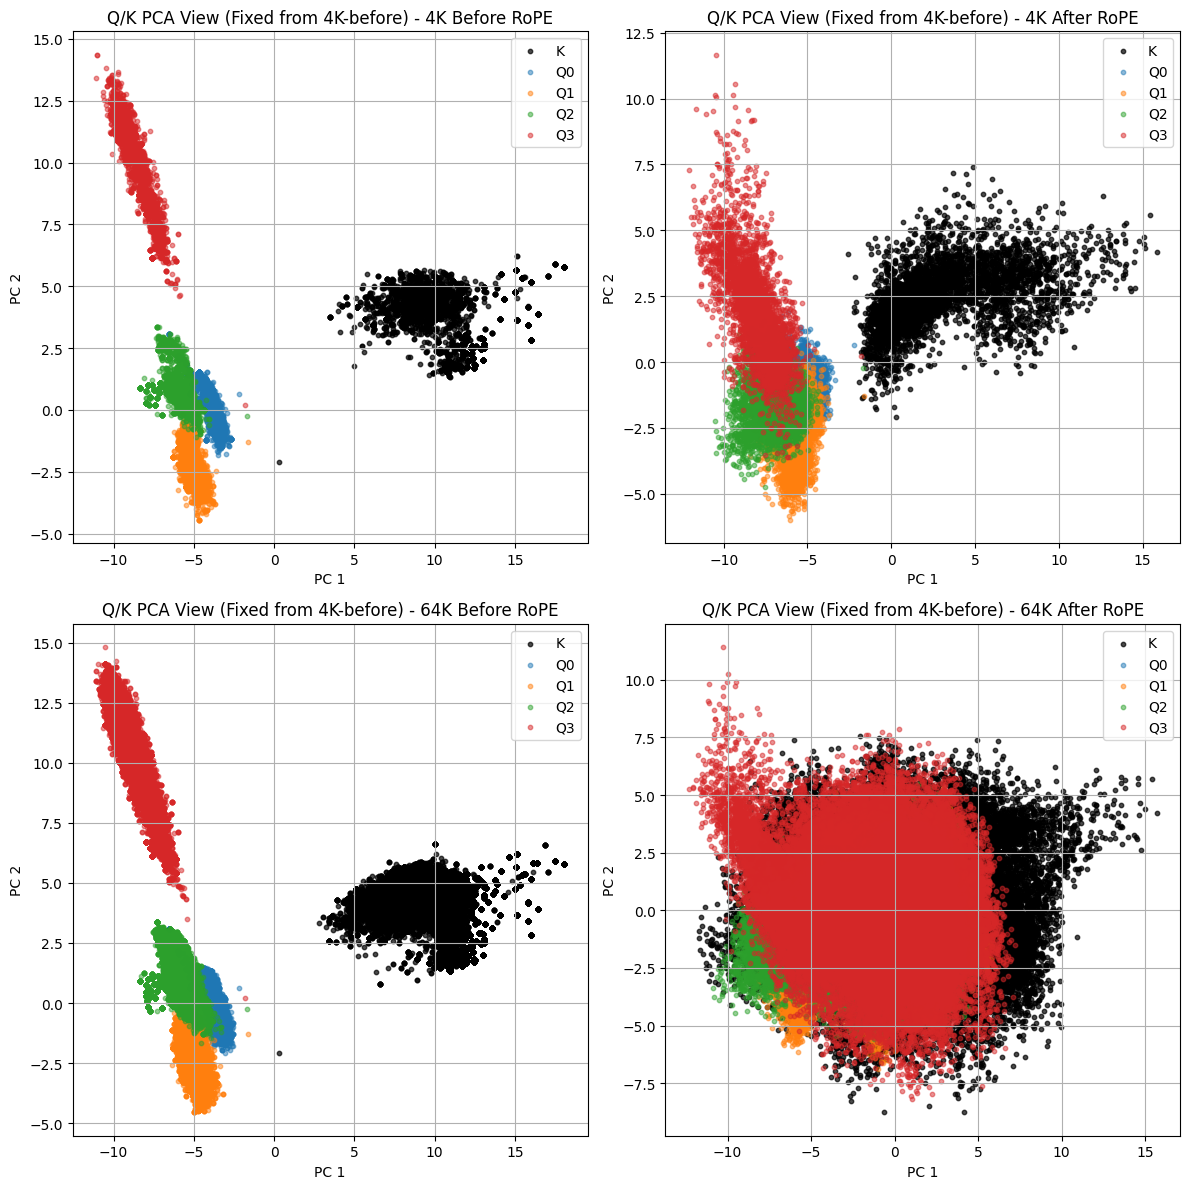

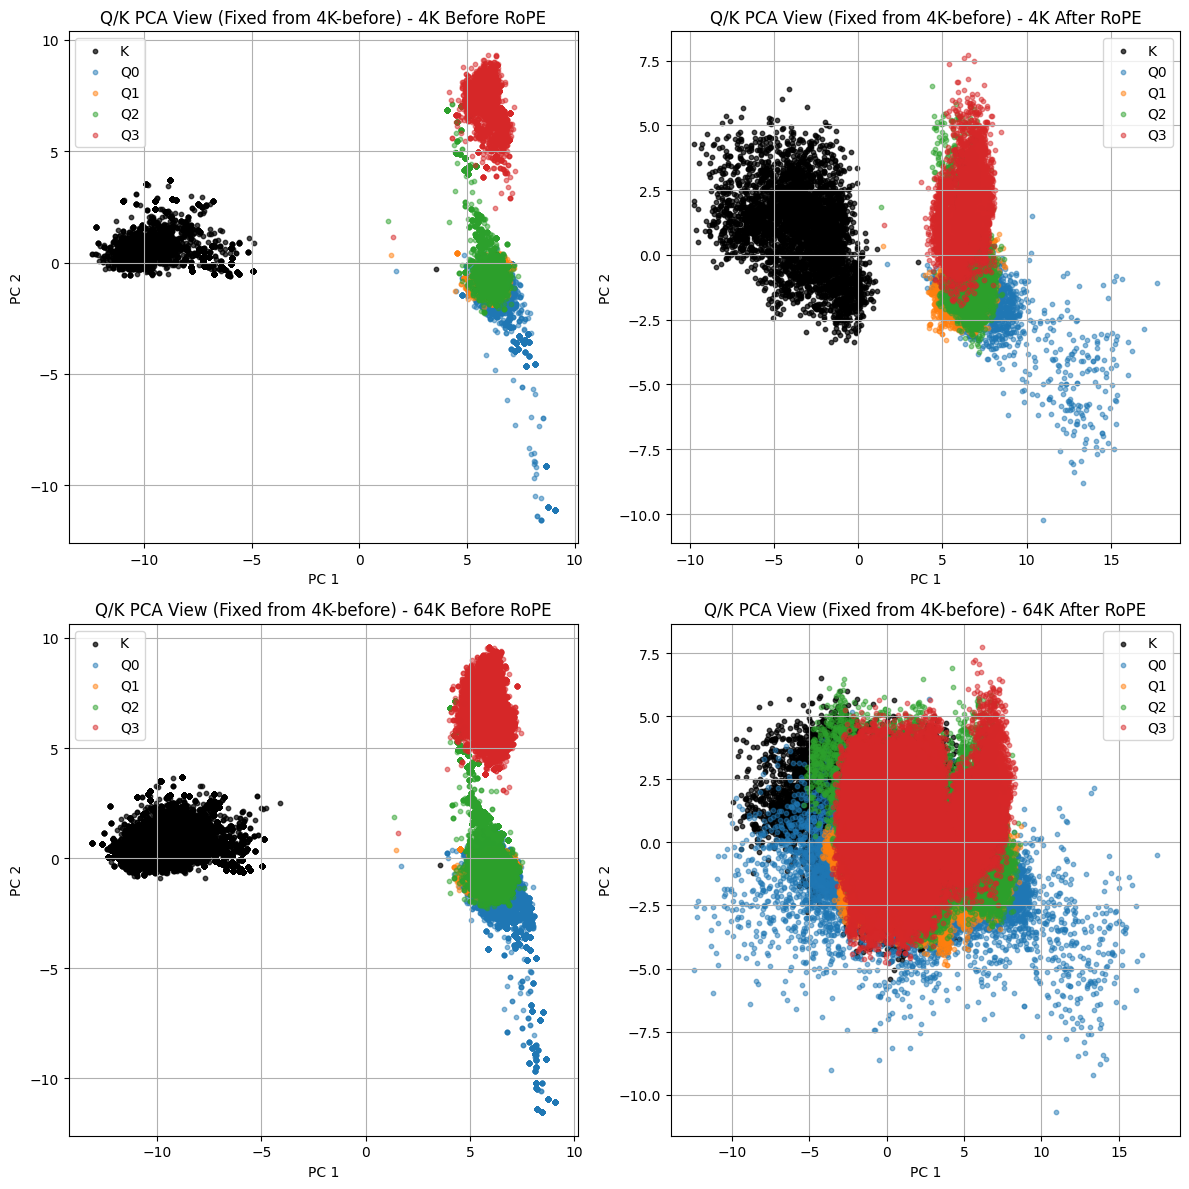

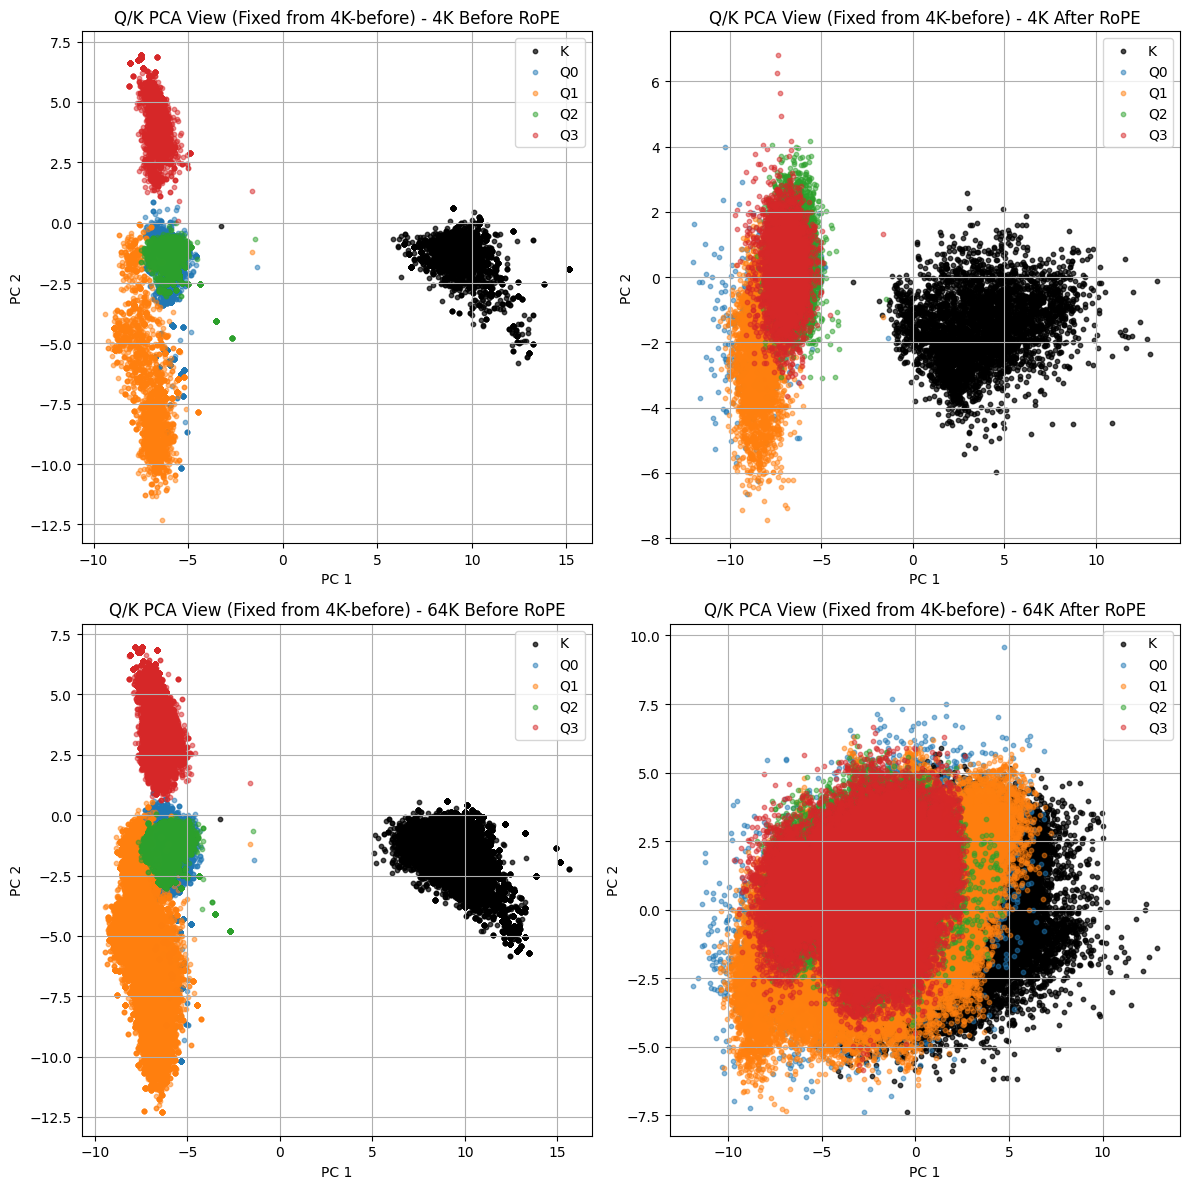

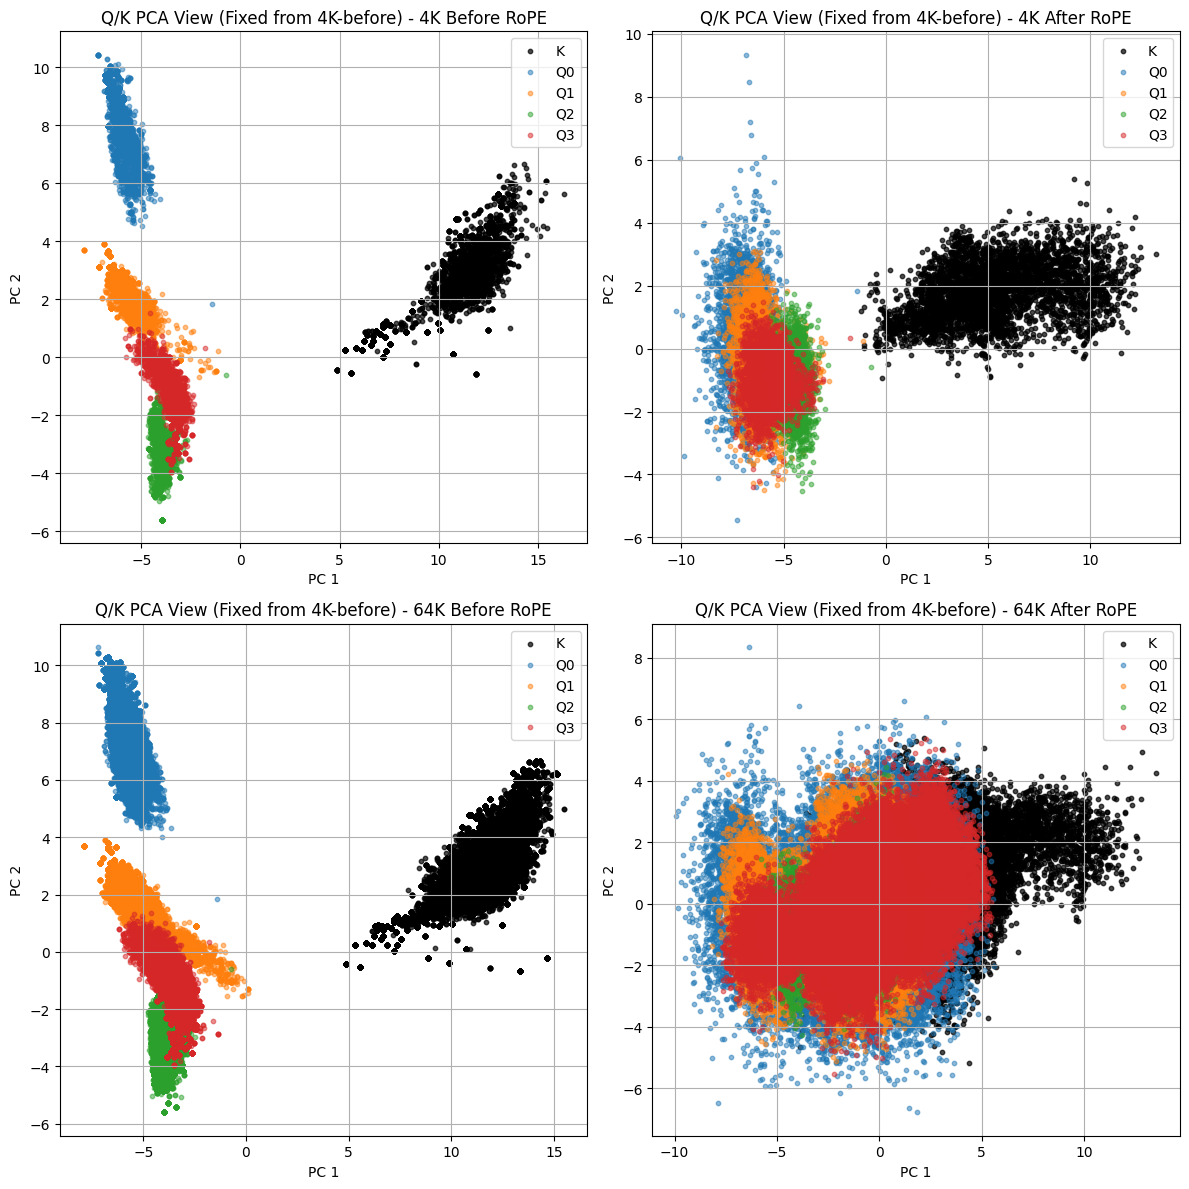

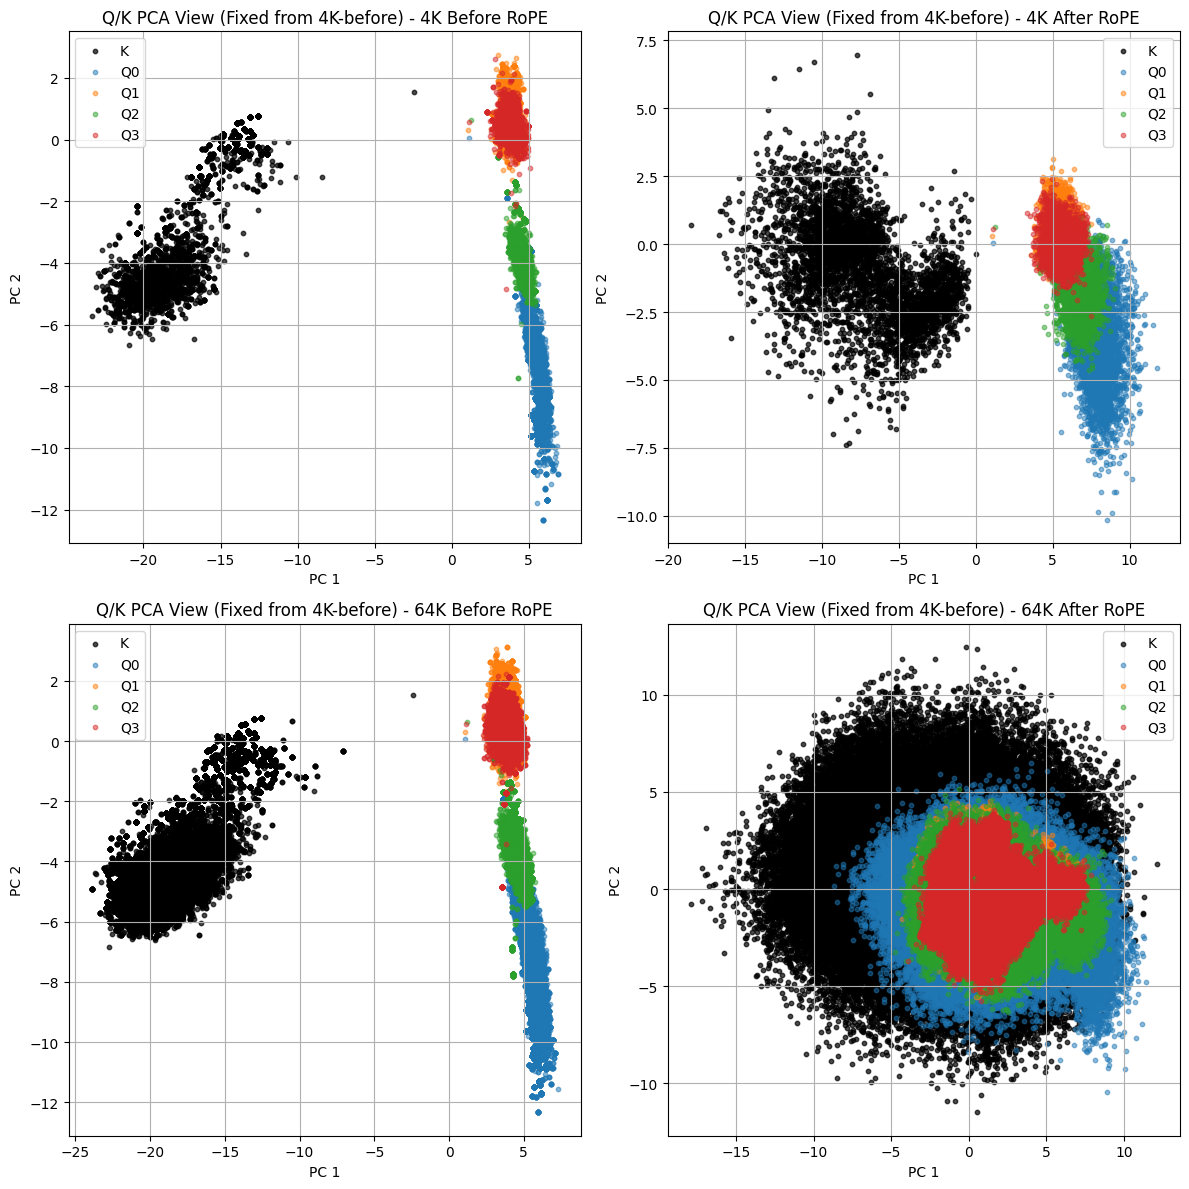

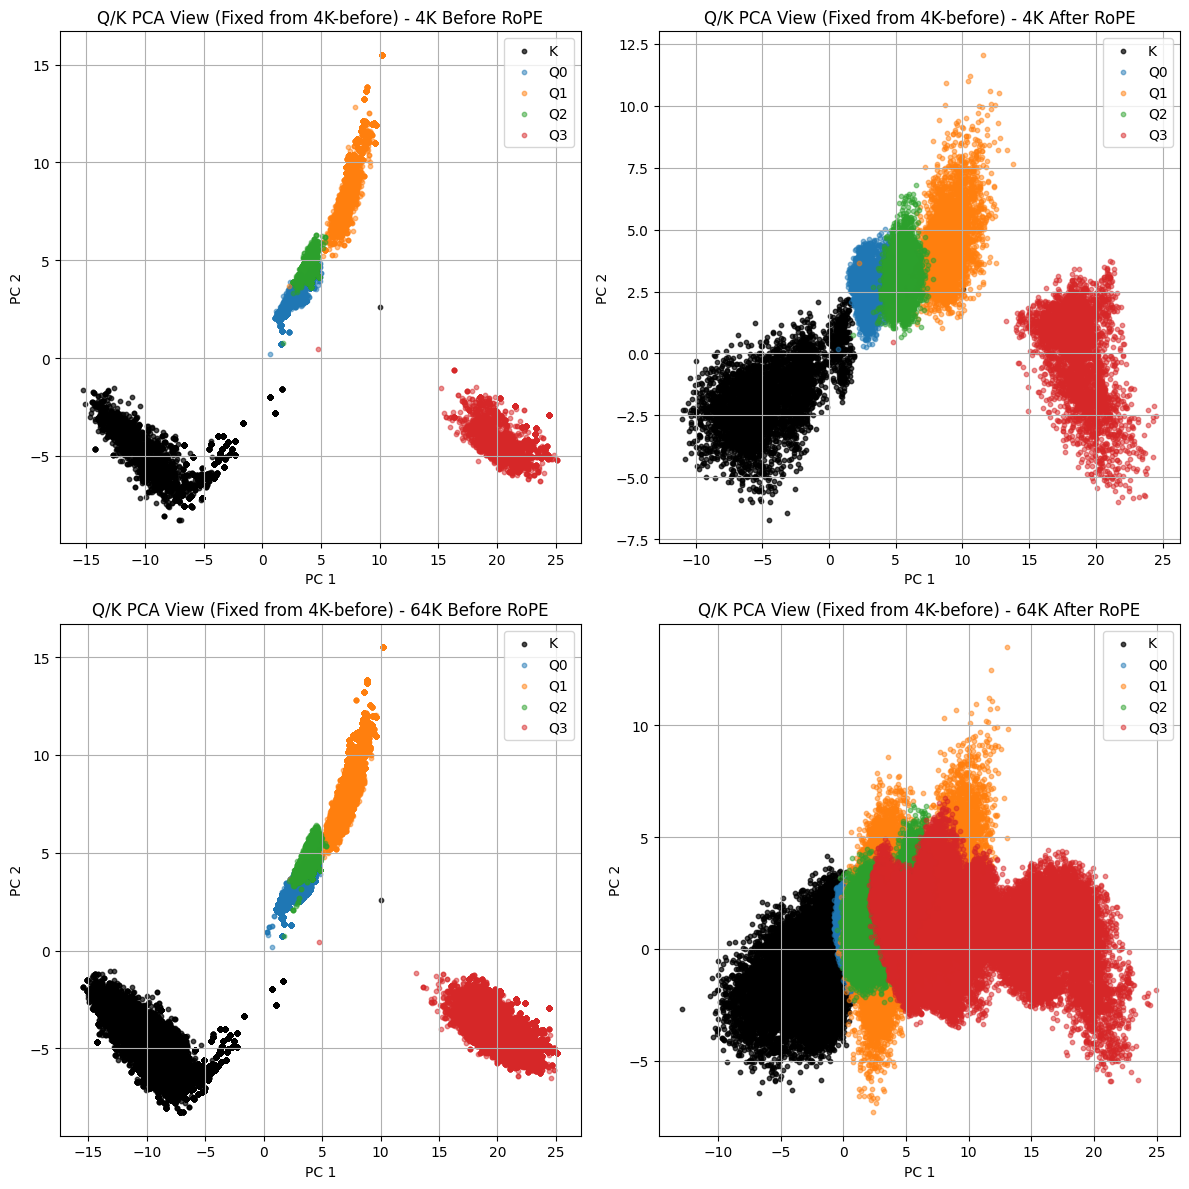

In [3]:
for target_head in range(8):
    Q_head_0_4k = Q_4k[4*target_head].float()  # shape [L, d]
    Q_head_1_4k = Q_4k[4*target_head+1].float()
    Q_head_2_4k = Q_4k[4*target_head+2].float()
    Q_head_3_4k = Q_4k[4*target_head+3].float()
    K_head_4k = K_4k[target_head].float()

    Q_list_4k = []
    Q_list_4k.append(Q_head_0_4k)
    Q_list_4k.append(Q_head_1_4k)
    Q_list_4k.append(Q_head_2_4k)
    Q_list_4k.append(Q_head_3_4k)

    # after rope 4k
    Q_head_0_4k_rope = Q_4k_rope[4*target_head].float()  # shape [L, d]
    Q_head_1_4k_rope = Q_4k_rope[4*target_head+1].float()
    Q_head_2_4k_rope = Q_4k_rope[4*target_head+2].float()
    Q_head_3_4k_rope = Q_4k_rope[4*target_head+3].float()
    K_head_4k_rope = K_4k_rope[target_head].float()

    Q_list_4k_rope = []
    Q_list_4k_rope.append(Q_head_0_4k_rope)
    Q_list_4k_rope.append(Q_head_1_4k_rope)
    Q_list_4k_rope.append(Q_head_2_4k_rope)
    Q_list_4k_rope.append(Q_head_3_4k_rope)

    # before rope 64k
    Q_head_0_64k = Q_64k[4*target_head].float()  # shape [L, d]
    Q_head_1_64k = Q_64k[4*target_head+1].float()
    Q_head_2_64k = Q_64k[4*target_head+2].float()
    Q_head_3_64k = Q_64k[4*target_head+3].float()
    K_head_64k = K_64k[target_head].float()

    Q_list_64k = []
    Q_list_64k.append(Q_head_0_64k)
    Q_list_64k.append(Q_head_1_64k)
    Q_list_64k.append(Q_head_2_64k)
    Q_list_64k.append(Q_head_3_64k)

    # after rope 64k
    Q_head_0_64k_rope = Q_64k_rope[4*target_head].float()  # shape [L, d]
    Q_head_1_64k_rope = Q_64k_rope[4*target_head+1].float()
    Q_head_2_64k_rope = Q_64k_rope[4*target_head+2].float()
    Q_head_3_64k_rope = Q_64k_rope[4*target_head+3].float()
    K_head_64k_rope = K_64k_rope[target_head].float()

    Q_list_64k_rope = []
    Q_list_64k_rope.append(Q_head_0_64k_rope)
    Q_list_64k_rope.append(Q_head_1_64k_rope)
    Q_list_64k_rope.append(Q_head_2_64k_rope)
    Q_list_64k_rope.append(Q_head_3_64k_rope)

    plot_qk_shared_projection_from_4k_before(k_4k_before=K_head_4k, q_4k_before=Q_list_4k, 
                                            k_4k_after=K_head_4k_rope, q_4k_after=Q_list_4k_rope,
                                            k_64k_before=K_head_64k, q_64k_before=Q_list_64k,
                                            k_64k_after=K_head_64k_rope, q_64k_after=Q_list_64k_rope,
                                            layer=target_layer, head=target_head)